In [2]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from torchvision import transforms

from trainer import fit
import numpy as np

cuda = torch.cuda.is_available()

In [3]:
# Set up data loaders
from datasets import NormalDataset

root_dir = '/home/cuong/AIC20-Track2/AIC20_track2/AIC20_ReID/image_train'
train_csv = 'cls_train.csv'
val_csv = 'cls_val.csv'
label_json = 'train_image_metadata.json'

size = (224, 224)

train_dataset = NormalDataset(root_dir, train_csv, label_json,
                                       transform = transforms.Compose([
                                        transforms.Resize(size),  
                                        transforms.ToTensor()
                                      ]))
val_dataset = NormalDataset(root_dir, val_csv, label_json,
                                     transform = transforms.Compose([
                                        transforms.Resize(size),
                                        transforms.ToTensor()
                                      ]))

batch_size = 8
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [4]:
PATH = 'triplet-b4-200403.pth'
model = torch.load(PATH)

In [9]:
import random

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import MDS

num_classes = 100
r = lambda: random.randint(0,255)

classes = [str(i) for i in range(num_classes)]
colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(num_classes)]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(num_classes):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)
    
def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            mds_embedding = MDS(n_components=2)
            mds_transformed = mds_embedding.fit_transform(model.get_embedding(images).data.cpu().numpy())
            embeddings[k:k+len(images)] = mds_transformed
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

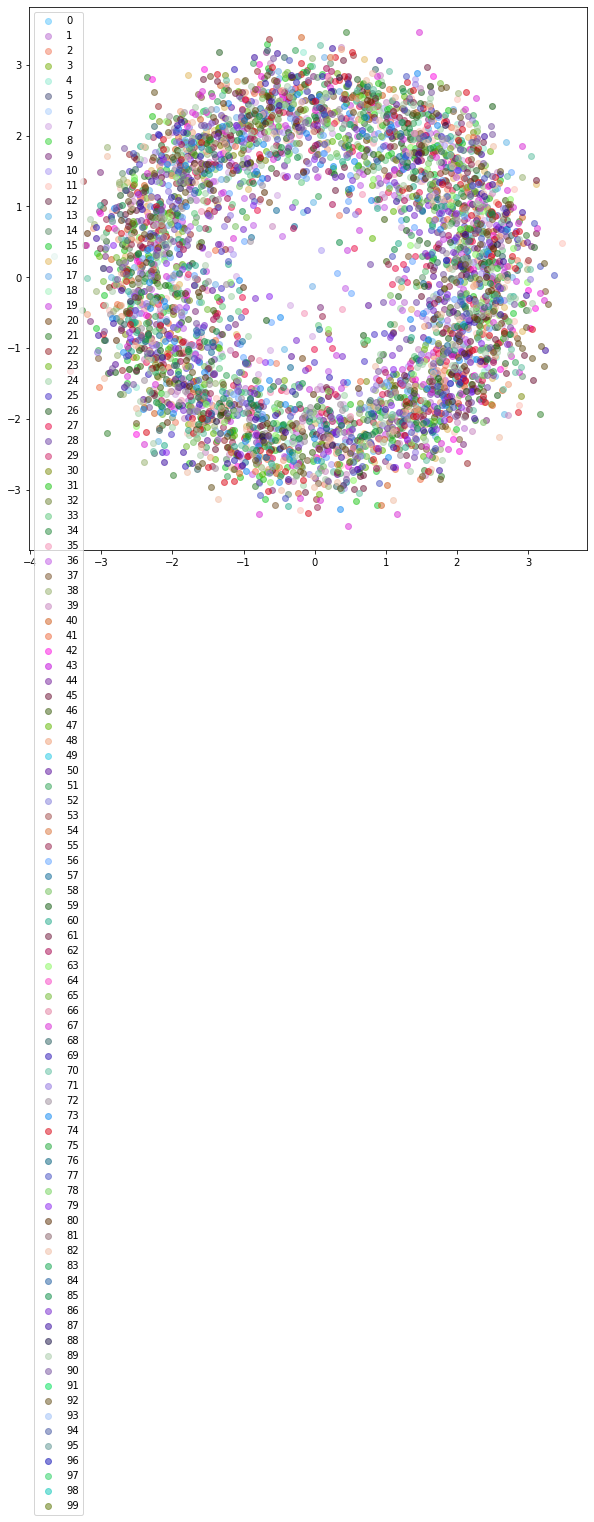

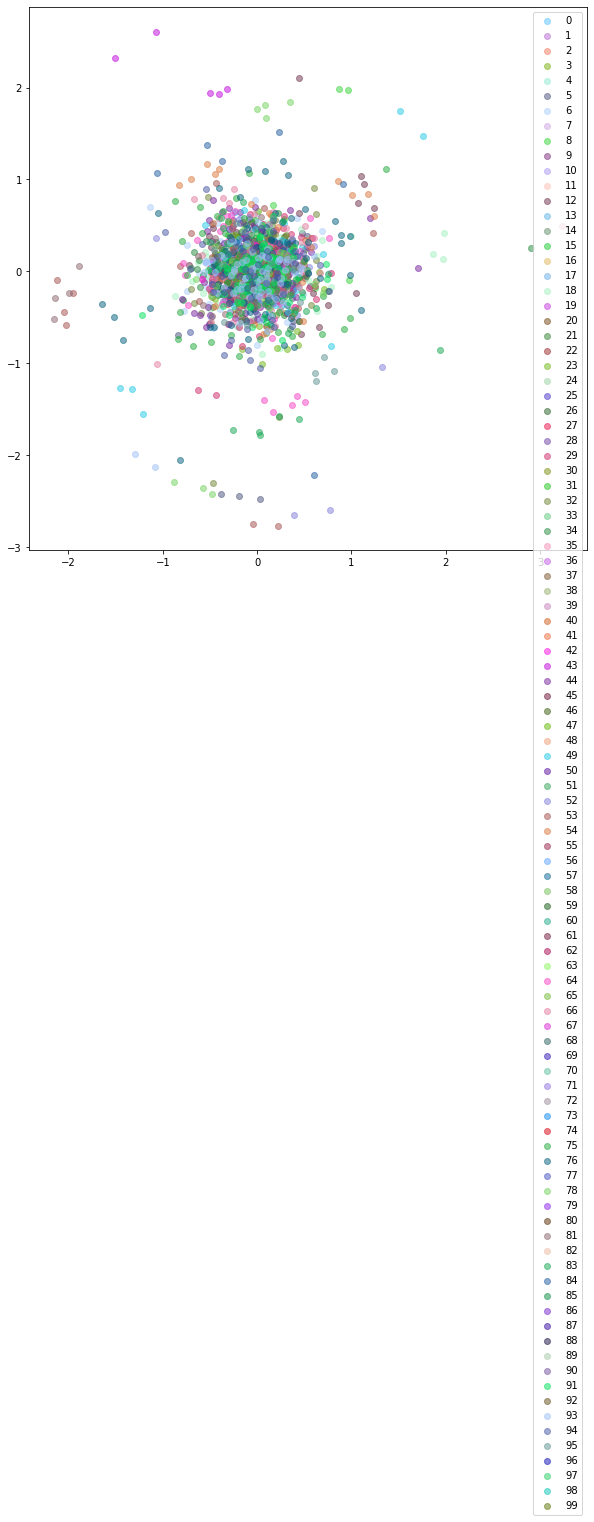

In [10]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(val_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)